<a href="https://colab.research.google.com/github/MichelleAppel/distribution-aware-image-to-image-translation/blob/master/toy_examples/fly_VAE_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os.path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms

from itertools import chain

import numpy as np
import math
import itertools
import random

from scipy import signal

import matplotlib.pyplot as plt

import zipfile

# Fly data experiment

Todo:
*   Use annotations somehow
*   Improve networks: AE and weightnet are not tailored for 128x128 images

## The Dataset

In [ ]:
zipdataroot_A = '/content/drive/MyDrive/fly_data_ubc_2021/generated_fly_with_annotation.zip'
zipdataroot_B = '/content/drive/MyDrive/fly_data_ubc_2021/real_fly.zip'

dataroot_A = '/content/flydata/data_A'
dataroot_B = '/content/flydata/data_B'

if not os.path.exists(dataroot_A):
  with zipfile.ZipFile(zipdataroot_A, 'r') as zip_ref:
      zip_ref.extractall(dataroot_A)

if not os.path.exists(dataroot_B):
  with zipfile.ZipFile(zipdataroot_B, 'r') as zip_ref:
      zip_ref.extractall(dataroot_B)

In [ ]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname) and not fname.endswith('real_A.png') and not fname.endswith('render_pose.png'):
                path = os.path.join(root, fname)
                images.append(path)

    return images

In [ ]:
def __adjust(img):
    ow, oh = img.size

    # the size needs to be a multiple of this number,
    # because going through generator network may change img size
    # and eventually cause size mismatch error
    mult = 4
    if ow % mult == 0 and oh % mult == 0:
        return img
    w = (ow - 1) // mult
    w = (w + 1) * mult
    h = (oh - 1) // mult
    h = (h + 1) * mult

    return img.resize((w, h), Image.BICUBIC)

def normalize(img):
  return img * 2 - 1


def get_transform():
    loadSize = 128
    osize = [loadSize, loadSize]

    transform_list = []
    transform_list.append(transforms.Lambda(
            lambda img: __adjust(img)))
    
    transform_list.append(transforms.Resize(osize, Image.BICUBIC))  
    transform_list += [transforms.ToTensor()]
                      #  transforms.Normalize((0.5, 0.5, 0.5),
                      #                       (0.5, 0.5, 0.5))]
    transform_list.append(transforms.Lambda(
            lambda img: normalize(img)))
    
    return transforms.Compose(transform_list)

In [ ]:
class FlyDataset(Dataset):
  def __init__(self):
    self.dataroot_A = dataroot_A
    self.dataroot_B = dataroot_B

    self.A_paths = make_dataset(self.dataroot_A)
    self.B_paths = make_dataset(self.dataroot_B)

    self.A_size = len(self.A_paths)
    self.B_size = len(self.B_paths)

    self.dir_len = len(self.dataroot_A) + 1

    self.transform = get_transform()

  def __getitem__(self, index):
      A_path = self.A_paths[index % self.A_size]
      A_name = A_path[self.dir_len:]
      
      index_B = random.randint(0, self.B_size - 1)
          
      B_path = self.B_paths[index_B]

      A_img = Image.open(A_path).convert('RGB')
      B_img = Image.open(B_path).convert('RGB')

      A = self.transform(A_img)
      B = self.transform(B_img)

      return {'A': A, 'B': B}

  def __len__(self):
    return max(self.A_size, self.B_size)

In [ ]:
dataset = FlyDataset()

batch_size = 32
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
def visualize(img):
  plt.imshow((img.permute(1,2,0) + 1) / 2)
  plt.show()

## The Networks

TODO: improve networks

In [ ]:
class VAE(nn.Module):
    def __init__(self, zsize, layer_count=5, channels=3):
        super(VAE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(inputs * 4 * 4, zsize)
        self.fc2 = nn.Linear(inputs * 4 * 4, zsize)

        self.d1 = nn.Linear(zsize, inputs * 4 * 4)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))

    def encode(self, x):
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))

        x = x.view(x.shape[0], self.d_max * 4 * 4)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 4, 4)
        #x = self.deconv1_bn(x)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

## Training

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.mean((recon_x - x)**2)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1))
    return BCE, KLD * 0.1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 0 step 0 loss_re_A 0.9935580492019653 loss_kl_A 0.012558328919112682 loss_re_B 1.0045360326766968 loss_kl_B 0.01239632535725832


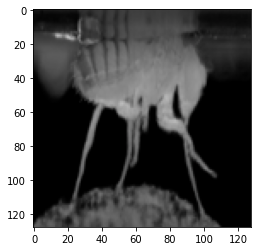

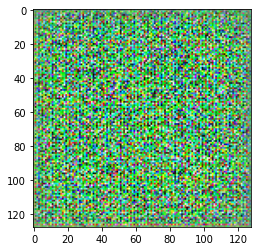

epoch 0 step 10 loss_re_A 0.400924414396286 loss_kl_A 0.13565203547477722 loss_re_B 0.40333837270736694 loss_kl_B 0.13538746535778046
epoch 0 step 20 loss_re_A 0.2242320030927658 loss_kl_A 0.03952474519610405 loss_re_B 0.22740331292152405 loss_kl_B 0.03958803042769432
epoch 0 step 30 loss_re_A 0.24951481819152832 loss_kl_A 0.030605962499976158 loss_re_B 0.2486005425453186 loss_kl_B 0.030886445194482803
epoch 0 step 40 loss_re_A 0.17485961318016052 loss_kl_A 0.23843340575695038 loss_re_B 0.1776193380355835 loss_kl_B 0.23804950714111328
epoch 1 step 0 loss_re_A 0.17343026399612427 loss_kl_A 0.24051561951637268 loss_re_B 0.17813244462013245 loss_kl_B 0.24070489406585693


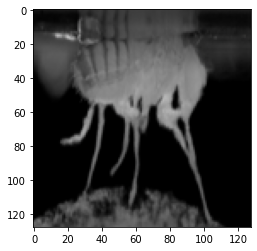

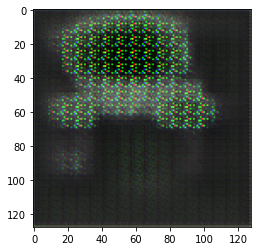

epoch 1 step 10 loss_re_A 0.1983182430267334 loss_kl_A 0.02242164872586727 loss_re_B 0.21631333231925964 loss_kl_B 0.022415118291974068
epoch 1 step 20 loss_re_A 0.12341265380382538 loss_kl_A 0.09825704246759415 loss_re_B 0.12414686381816864 loss_kl_B 0.09891057014465332
epoch 1 step 30 loss_re_A 0.07195283472537994 loss_kl_A 0.07161247730255127 loss_re_B 0.07575713098049164 loss_kl_B 0.07088097184896469
epoch 1 step 40 loss_re_A 0.06630140542984009 loss_kl_A 0.12805601954460144 loss_re_B 0.07080432772636414 loss_kl_B 0.12892405688762665
epoch 2 step 0 loss_re_A 0.12546275556087494 loss_kl_A 0.022950073704123497 loss_re_B 0.11970444768667221 loss_kl_B 0.02294805459678173


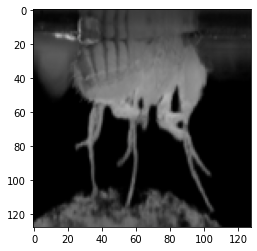

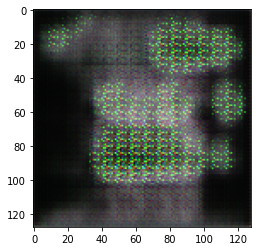

epoch 2 step 10 loss_re_A 0.05805496126413345 loss_kl_A 0.018372435122728348 loss_re_B 0.061700593680143356 loss_kl_B 0.01866014674305916
epoch 2 step 20 loss_re_A 0.07177835702896118 loss_kl_A 0.03872161731123924 loss_re_B 0.07721125334501266 loss_kl_B 0.03876335918903351
epoch 2 step 30 loss_re_A 0.04329664632678032 loss_kl_A 0.010365482419729233 loss_re_B 0.04908481240272522 loss_kl_B 0.010713756084442139
epoch 2 step 40 loss_re_A 0.045441918075084686 loss_kl_A 0.17321324348449707 loss_re_B 0.051518917083740234 loss_kl_B 0.17309819161891937
epoch 3 step 0 loss_re_A 0.04045183211565018 loss_kl_A 0.03961985185742378 loss_re_B 0.047261349856853485 loss_kl_B 0.0397309772670269


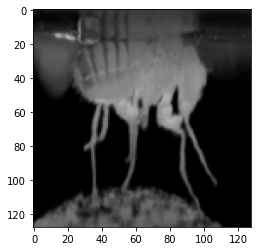

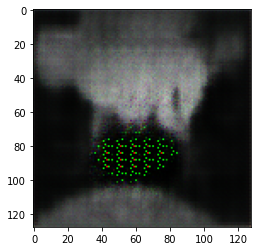

epoch 3 step 10 loss_re_A 0.07653972506523132 loss_kl_A 0.10749702900648117 loss_re_B 0.07982045412063599 loss_kl_B 0.10446470975875854
epoch 3 step 20 loss_re_A 0.07693947851657867 loss_kl_A 0.01858781836926937 loss_re_B 0.08081452548503876 loss_kl_B 0.01901601441204548
epoch 3 step 30 loss_re_A 0.0314418189227581 loss_kl_A 0.011754042468965054 loss_re_B 0.04051872715353966 loss_kl_B 0.011886384338140488
epoch 3 step 40 loss_re_A 0.02866435796022415 loss_kl_A 0.006062889005988836 loss_re_B 0.037130389362573624 loss_kl_B 0.006315506994724274
epoch 4 step 0 loss_re_A 0.03583882004022598 loss_kl_A 0.002099250676110387 loss_re_B 0.04026828706264496 loss_kl_B 0.0022544299717992544


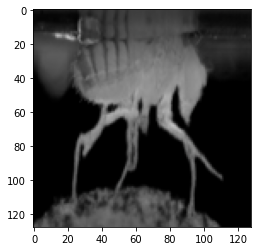

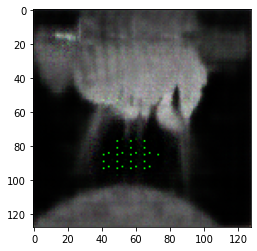

epoch 4 step 10 loss_re_A 0.026628803461790085 loss_kl_A 0.04706946387887001 loss_re_B 0.033477794378995895 loss_kl_B 0.04740117862820625
epoch 4 step 20 loss_re_A 0.027077890932559967 loss_kl_A 0.0014960768166929483 loss_re_B 0.033202022314071655 loss_kl_B 0.0016288704937323928
epoch 4 step 30 loss_re_A 0.025966163724660873 loss_kl_A 0.0011424965923652053 loss_re_B 0.034597840160131454 loss_kl_B 0.0013232209021225572
epoch 4 step 40 loss_re_A 0.02495623007416725 loss_kl_A 0.001727687194943428 loss_re_B 0.032308775931596756 loss_kl_B 0.0017978206742554903
epoch 5 step 0 loss_re_A 0.024252139031887054 loss_kl_A 0.0008596236002631485 loss_re_B 0.03228633105754852 loss_kl_B 0.0009520130115561187


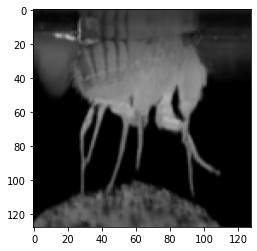

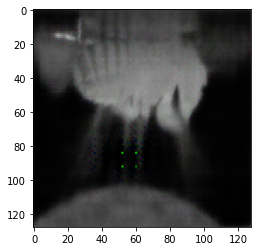

epoch 5 step 10 loss_re_A 0.023111825808882713 loss_kl_A 0.017039695754647255 loss_re_B 0.031091708689928055 loss_kl_B 0.01710461638867855
epoch 5 step 20 loss_re_A 0.025022372603416443 loss_kl_A 0.0010298086563125253 loss_re_B 0.031113510951399803 loss_kl_B 0.001164894551038742
epoch 5 step 30 loss_re_A 0.023798350244760513 loss_kl_A 0.001951809274032712 loss_re_B 0.030135229229927063 loss_kl_B 0.0019847084768116474
epoch 5 step 40 loss_re_A 0.02290274016559124 loss_kl_A 0.0017214646795764565 loss_re_B 0.029510822147130966 loss_kl_B 0.0017626576591283083
epoch 6 step 0 loss_re_A 0.021961573511362076 loss_kl_A 0.001843618811108172 loss_re_B 0.030609464272856712 loss_kl_B 0.0018957741558551788


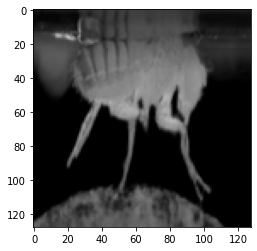

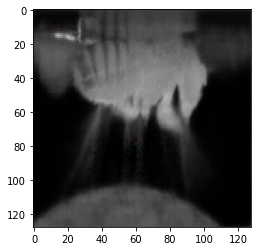

epoch 6 step 10 loss_re_A 0.026458721607923508 loss_kl_A 0.0014372736914083362 loss_re_B 0.03269664943218231 loss_kl_B 0.001547686755657196
epoch 6 step 20 loss_re_A 0.02806168422102928 loss_kl_A 0.010139352641999722 loss_re_B 0.036331161856651306 loss_kl_B 0.010125009343028069
epoch 6 step 30 loss_re_A 0.0261840857565403 loss_kl_A 0.0015051455702632666 loss_re_B 0.032085120677948 loss_kl_B 0.0014976495876908302
epoch 6 step 40 loss_re_A 0.0236385278403759 loss_kl_A 0.0009793936042115092 loss_re_B 0.029697701334953308 loss_kl_B 0.0009725647978484631
learning rate change!
epoch 7 step 0 loss_re_A 0.02264724299311638 loss_kl_A 0.003075187560170889 loss_re_B 0.02946021780371666 loss_kl_B 0.0031674173660576344


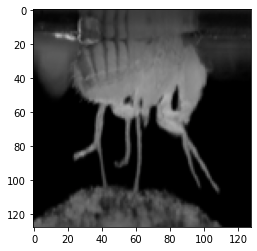

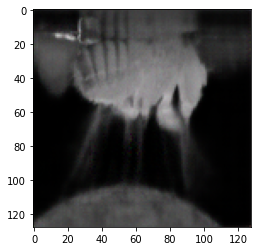

epoch 7 step 10 loss_re_A 0.02217012271285057 loss_kl_A 0.001115672173909843 loss_re_B 0.02913558855652809 loss_kl_B 0.0010972217423841357
epoch 7 step 20 loss_re_A 0.02268839441239834 loss_kl_A 0.0011904177954420447 loss_re_B 0.02904946357011795 loss_kl_B 0.001145950867794454
epoch 7 step 30 loss_re_A 0.023364264518022537 loss_kl_A 0.0008569186902604997 loss_re_B 0.02939864993095398 loss_kl_B 0.0008455706993117929
epoch 7 step 40 loss_re_A 0.02285594493150711 loss_kl_A 0.0009374281507916749 loss_re_B 0.030033309012651443 loss_kl_B 0.0009326754952780902
epoch 8 step 0 loss_re_A 0.021859824657440186 loss_kl_A 0.000903490639757365 loss_re_B 0.0291350856423378 loss_kl_B 0.0008691716357134283


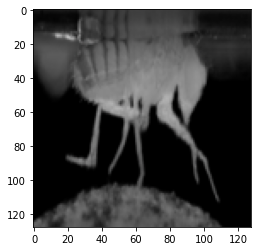

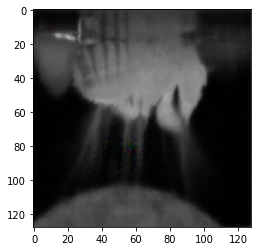

epoch 8 step 10 loss_re_A 0.02207229658961296 loss_kl_A 0.001224174746312201 loss_re_B 0.029614124447107315 loss_kl_B 0.00119272421579808
epoch 8 step 20 loss_re_A 0.022825006395578384 loss_kl_A 0.0010439105099067092 loss_re_B 0.028230253607034683 loss_kl_B 0.0010161286918446422
epoch 8 step 30 loss_re_A 0.022348737344145775 loss_kl_A 0.0008022263064049184 loss_re_B 0.02932860516011715 loss_kl_B 0.0008112728828564286
epoch 8 step 40 loss_re_A 0.02244480699300766 loss_kl_A 0.0009554213029332459 loss_re_B 0.028591757640242577 loss_kl_B 0.0009081187890842557
epoch 9 step 0 loss_re_A 0.022475024685263634 loss_kl_A 0.0010008517419919372 loss_re_B 0.03035537526011467 loss_kl_B 0.000959885714109987


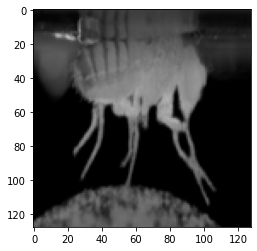

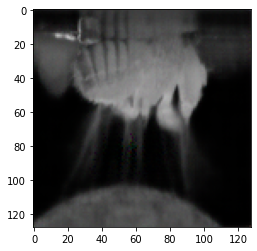

epoch 9 step 10 loss_re_A 0.022781042382121086 loss_kl_A 0.0009246956906281412 loss_re_B 0.030177105218172073 loss_kl_B 0.0009115368011407554
epoch 9 step 20 loss_re_A 0.021231114864349365 loss_kl_A 0.0008499581599608064 loss_re_B 0.028500905260443687 loss_kl_B 0.0008185828919522464
epoch 9 step 30 loss_re_A 0.021800369024276733 loss_kl_A 0.0009091703104786575 loss_re_B 0.02911047264933586 loss_kl_B 0.0008181187440641224
epoch 9 step 40 loss_re_A 0.02224879525601864 loss_kl_A 0.0009495707345195115 loss_re_B 0.029188036918640137 loss_kl_B 0.0008863733964972198
epoch 10 step 0 loss_re_A 0.022157160565257072 loss_kl_A 0.0008203284232877195 loss_re_B 0.02946365997195244 loss_kl_B 0.0008018469670787454


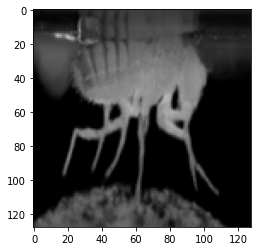

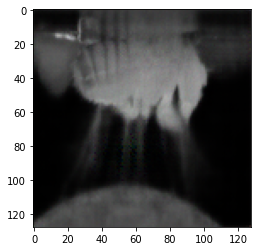

epoch 10 step 10 loss_re_A 0.022724952548742294 loss_kl_A 0.0009460058063268661 loss_re_B 0.028228774666786194 loss_kl_B 0.0009471589000895619
epoch 10 step 20 loss_re_A 0.022481804713606834 loss_kl_A 0.0008306046947836876 loss_re_B 0.02970070205628872 loss_kl_B 0.0008048603194765747
epoch 10 step 30 loss_re_A 0.02287737838923931 loss_kl_A 0.0007677908870391548 loss_re_B 0.028823187574744225 loss_kl_B 0.000754745677113533
epoch 10 step 40 loss_re_A 0.022826295346021652 loss_kl_A 0.0008424088591709733 loss_re_B 0.027717124670743942 loss_kl_B 0.0007740084547549486
epoch 11 step 0 loss_re_A 0.022124823182821274 loss_kl_A 0.0009992601117119193 loss_re_B 0.029840867966413498 loss_kl_B 0.0009094674023799598


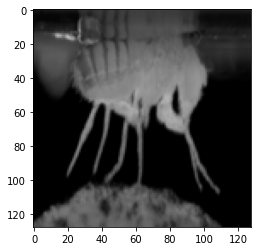

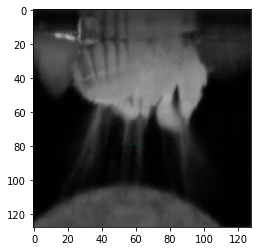

epoch 11 step 10 loss_re_A 0.022536203265190125 loss_kl_A 0.0009961733594536781 loss_re_B 0.028628168627619743 loss_kl_B 0.0009416734683327377
epoch 11 step 20 loss_re_A 0.022415049374103546 loss_kl_A 0.001039072754792869 loss_re_B 0.027235185727477074 loss_kl_B 0.0009159545297734439
epoch 11 step 30 loss_re_A 0.021522827446460724 loss_kl_A 0.0012984040658921003 loss_re_B 0.028931422159075737 loss_kl_B 0.001216912642121315
epoch 11 step 40 loss_re_A 0.022038210183382034 loss_kl_A 0.0012989677488803864 loss_re_B 0.02874663844704628 loss_kl_B 0.0011120995040982962
epoch 12 step 0 loss_re_A 0.022690070793032646 loss_kl_A 0.001083528040908277 loss_re_B 0.026760853826999664 loss_kl_B 0.0008538942784070969


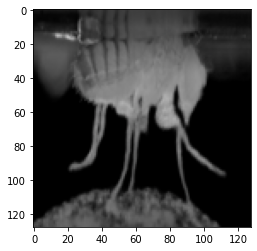

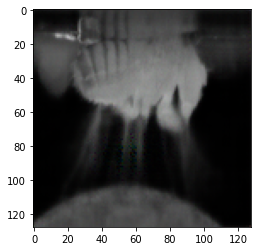

epoch 12 step 10 loss_re_A 0.021579090505838394 loss_kl_A 0.001217025681398809 loss_re_B 0.028174087405204773 loss_kl_B 0.0011623859172686934
epoch 12 step 20 loss_re_A 0.022651072591543198 loss_kl_A 0.0007921583019196987 loss_re_B 0.027783317491412163 loss_kl_B 0.0009604727965779603
epoch 12 step 30 loss_re_A 0.021783702075481415 loss_kl_A 0.000990664935670793 loss_re_B 0.027783220633864403 loss_kl_B 0.0009126810473389924
epoch 12 step 40 loss_re_A 0.021488070487976074 loss_kl_A 0.0012572038685902953 loss_re_B 0.0282838623970747 loss_kl_B 0.0011136755347251892
epoch 13 step 0 loss_re_A 0.021014060825109482 loss_kl_A 0.0010691412026062608 loss_re_B 0.02602851763367653 loss_kl_B 0.0011687305523082614


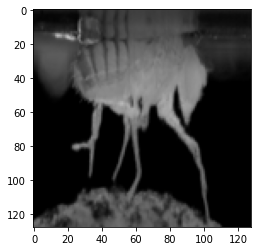

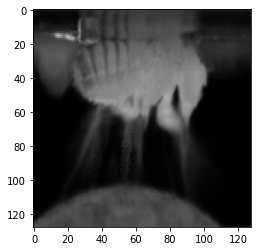

epoch 13 step 10 loss_re_A 0.02211819402873516 loss_kl_A 0.0010793913388624787 loss_re_B 0.026956763118505478 loss_kl_B 0.0010606629075482488
epoch 13 step 20 loss_re_A 0.021268775686621666 loss_kl_A 0.0009789386531338096 loss_re_B 0.027978381142020226 loss_kl_B 0.0008897205698303878
epoch 13 step 30 loss_re_A 0.021758437156677246 loss_kl_A 0.0009830034105107188 loss_re_B 0.0268806591629982 loss_kl_B 0.0011260813334956765
epoch 13 step 40 loss_re_A 0.022752922028303146 loss_kl_A 0.0010992104653269053 loss_re_B 0.026023905724287033 loss_kl_B 0.0011821226216852665
epoch 14 step 0 loss_re_A 0.022717256098985672 loss_kl_A 0.000775553984567523 loss_re_B 0.028236690908670425 loss_kl_B 0.0009394401567988098


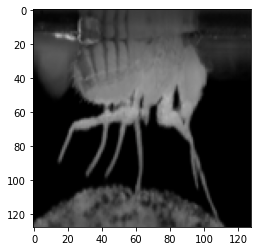

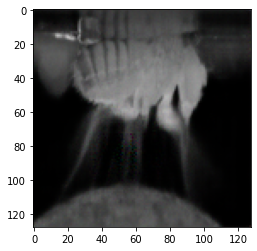

epoch 14 step 10 loss_re_A 0.021556204184889793 loss_kl_A 0.0016333794919773936 loss_re_B 0.02757108025252819 loss_kl_B 0.001284153200685978
epoch 14 step 20 loss_re_A 0.02280288003385067 loss_kl_A 0.0005912937340326607 loss_re_B 0.029182193800807 loss_kl_B 0.0009307367727160454
epoch 14 step 30 loss_re_A 0.02077411860227585 loss_kl_A 0.0018776621436700225 loss_re_B 0.028298942372202873 loss_kl_B 0.0015373051865026355
epoch 14 step 40 loss_re_A 0.02148168347775936 loss_kl_A 0.0025310306809842587 loss_re_B 0.029263099655508995 loss_kl_B 0.002191276988014579
learning rate change!
epoch 15 step 0 loss_re_A 0.0215139240026474 loss_kl_A 0.0009479278814978898 loss_re_B 0.02879418432712555 loss_kl_B 0.0010155938798561692


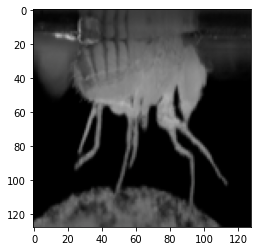

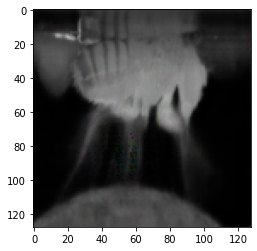

epoch 15 step 10 loss_re_A 0.020388422533869743 loss_kl_A 0.0010941922664642334 loss_re_B 0.027632635086774826 loss_kl_B 0.0010216411901637912
epoch 15 step 20 loss_re_A 0.021978672593832016 loss_kl_A 0.0009108750382438302 loss_re_B 0.024531546980142593 loss_kl_B 0.0010385708883404732
epoch 15 step 30 loss_re_A 0.020631888881325722 loss_kl_A 0.0010245407465845346 loss_re_B 0.026116512715816498 loss_kl_B 0.0009083137265406549
epoch 15 step 40 loss_re_A 0.021965693682432175 loss_kl_A 0.0009287350112572312 loss_re_B 0.02500395104289055 loss_kl_B 0.0009147044620476663
epoch 16 step 0 loss_re_A 0.02133745700120926 loss_kl_A 0.0011750790290534496 loss_re_B 0.026577088981866837 loss_kl_B 0.001297539914958179


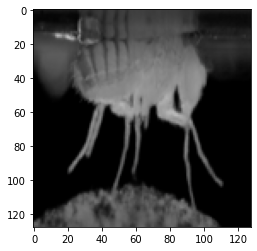

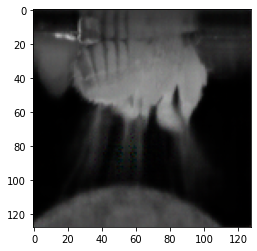

epoch 16 step 10 loss_re_A 0.020963309332728386 loss_kl_A 0.0009790342301130295 loss_re_B 0.02646883949637413 loss_kl_B 0.0010278740664944053
epoch 16 step 20 loss_re_A 0.021311556920409203 loss_kl_A 0.0010327795753255486 loss_re_B 0.023411016911268234 loss_kl_B 0.0010255174711346626
epoch 16 step 30 loss_re_A 0.02115596830844879 loss_kl_A 0.000855674035847187 loss_re_B 0.0246086698025465 loss_kl_B 0.0011132702929899096
epoch 16 step 40 loss_re_A 0.021248850971460342 loss_kl_A 0.001086538308300078 loss_re_B 0.025462154299020767 loss_kl_B 0.0010098167695105076
epoch 17 step 0 loss_re_A 0.021931370720267296 loss_kl_A 0.0010408504167571664 loss_re_B 0.024803634732961655 loss_kl_B 0.0009406983735971153


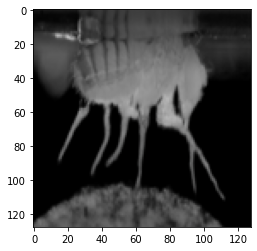

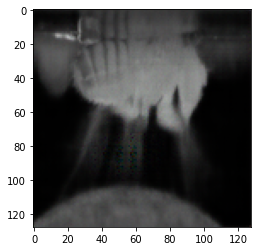

epoch 17 step 10 loss_re_A 0.02088148519396782 loss_kl_A 0.0010589751182124019 loss_re_B 0.025828277692198753 loss_kl_B 0.0011121315183117986
epoch 17 step 20 loss_re_A 0.0219697467982769 loss_kl_A 0.0010103185195475817 loss_re_B 0.02659456431865692 loss_kl_B 0.0009669174323789775
epoch 17 step 30 loss_re_A 0.02146541140973568 loss_kl_A 0.0010161370737478137 loss_re_B 0.024420231580734253 loss_kl_B 0.001064001815393567
epoch 17 step 40 loss_re_A 0.019908133894205093 loss_kl_A 0.0011902678525075316 loss_re_B 0.026261745020747185 loss_kl_B 0.0012448237976059318
epoch 18 step 0 loss_re_A 0.0210221316665411 loss_kl_A 0.0015898224664852023 loss_re_B 0.025838341563940048 loss_kl_B 0.0013044057413935661


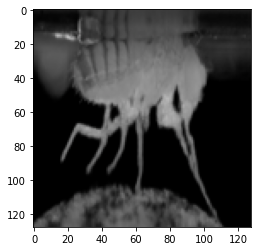

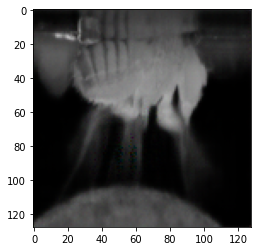

epoch 18 step 10 loss_re_A 0.021866288036108017 loss_kl_A 0.0009371397900395095 loss_re_B 0.024047231301665306 loss_kl_B 0.0011830412549898028
epoch 18 step 20 loss_re_A 0.021123938262462616 loss_kl_A 0.0011835454497486353 loss_re_B 0.026087686419487 loss_kl_B 0.0009695863700471818
epoch 18 step 30 loss_re_A 0.02239949256181717 loss_kl_A 0.0009136215085163713 loss_re_B 0.026529978960752487 loss_kl_B 0.000917664379812777
epoch 18 step 40 loss_re_A 0.022164996713399887 loss_kl_A 0.0011924559948965907 loss_re_B 0.025520626455545425 loss_kl_B 0.0010620768880471587
epoch 19 step 0 loss_re_A 0.02079400047659874 loss_kl_A 0.0011049205204471946 loss_re_B 0.02502528391778469 loss_kl_B 0.0011292373528704047


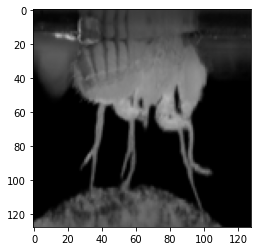

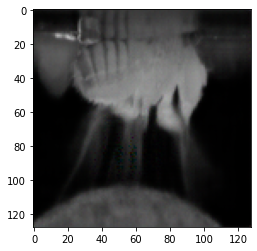

epoch 19 step 10 loss_re_A 0.02153969369828701 loss_kl_A 0.0010480047203600407 loss_re_B 0.022339170798659325 loss_kl_B 0.0012190239503979683
epoch 19 step 20 loss_re_A 0.020361600443720818 loss_kl_A 0.0010027264943346381 loss_re_B 0.02364562824368477 loss_kl_B 0.001077737077139318
epoch 19 step 30 loss_re_A 0.021357804536819458 loss_kl_A 0.0008781414362601936 loss_re_B 0.026126142591238022 loss_kl_B 0.0009022317826747894
epoch 19 step 40 loss_re_A 0.021532829850912094 loss_kl_A 0.000872658216394484 loss_re_B 0.02473929338157177 loss_kl_B 0.001092446269467473
epoch 20 step 0 loss_re_A 0.021257540211081505 loss_kl_A 0.0009253487223759294 loss_re_B 0.02557201310992241 loss_kl_B 0.0010872742859646678


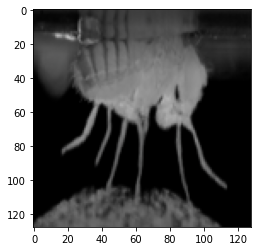

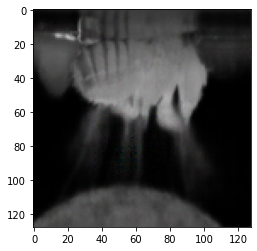

epoch 20 step 10 loss_re_A 0.020156534388661385 loss_kl_A 0.0009056813432835042 loss_re_B 0.024994876235723495 loss_kl_B 0.0010876652086153626
epoch 20 step 20 loss_re_A 0.021471550688147545 loss_kl_A 0.000991486362181604 loss_re_B 0.025743989273905754 loss_kl_B 0.0011167064076289535
epoch 20 step 30 loss_re_A 0.020310334861278534 loss_kl_A 0.00103973806835711 loss_re_B 0.023635033518075943 loss_kl_B 0.0012126723304390907
epoch 20 step 40 loss_re_A 0.020592596381902695 loss_kl_A 0.0011094146175310016 loss_re_B 0.0249059796333313 loss_kl_B 0.0010544505203142762
epoch 21 step 0 loss_re_A 0.020428935065865517 loss_kl_A 0.0012154245050624013 loss_re_B 0.024832259863615036 loss_kl_B 0.001127645024098456


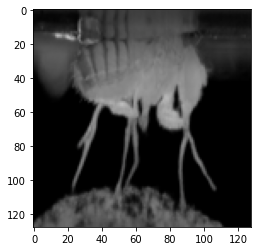

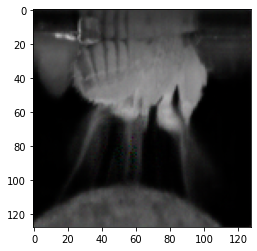

epoch 21 step 10 loss_re_A 0.021209102123975754 loss_kl_A 0.0011042424011975527 loss_re_B 0.02475675567984581 loss_kl_B 0.0010791292879730463
epoch 21 step 20 loss_re_A 0.020845897495746613 loss_kl_A 0.0010362338507547975 loss_re_B 0.024641796946525574 loss_kl_B 0.001112667960114777
epoch 21 step 30 loss_re_A 0.021044712513685226 loss_kl_A 0.00108559790533036 loss_re_B 0.026191186159849167 loss_kl_B 0.0010209400206804276
epoch 21 step 40 loss_re_A 0.021116461604833603 loss_kl_A 0.001006655627861619 loss_re_B 0.023460259661078453 loss_kl_B 0.001094912993721664
epoch 22 step 0 loss_re_A 0.021614830940961838 loss_kl_A 0.0006708409055136144 loss_re_B 0.022646641358733177 loss_kl_B 0.0013297488912940025


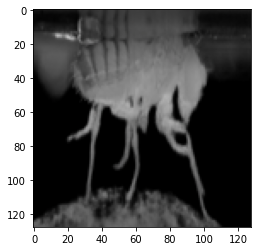

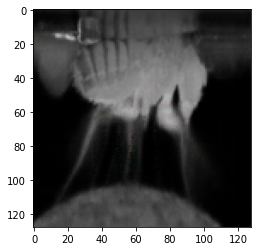

epoch 22 step 10 loss_re_A 0.019831988960504532 loss_kl_A 0.0010233698412775993 loss_re_B 0.023061862215399742 loss_kl_B 0.001103753107599914
epoch 22 step 20 loss_re_A 0.020440883934497833 loss_kl_A 0.0010213105706498027 loss_re_B 0.025409627705812454 loss_kl_B 0.0010353232501074672


In [ ]:
# Initialize the networks
vae = VAE(zsize=512).cuda()

# Initialize the optimizers
lr = 0.0005
vae_optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)

train_epoch = 40
# For storing results
rec_loss_A = []
rec_loss_B = []
kl_loss_A = []
kl_loss_B = []

for epoch in range(train_epoch):
    vae.train()

    if (epoch + 1) % 8 == 0:
        vae_optimizer.param_groups[0]['lr'] /= 4
        print("learning rate change!")

    for i, data in enumerate(dataloader):
        vae.train()
        vae.zero_grad()
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()

        # The embeddings
        rec_A, mu_A, logvar_A = vae(img_A)
        rec_B, mu_B, logvar_B = vae(img_B)

        # The loss function --------------------------------------------------------------------------------

        loss_re_A, loss_kl_A = loss_function(rec_A, img_A, mu_A, logvar_A)
        loss_re_B, loss_kl_B = loss_function(rec_B, img_B, mu_B, logvar_B)

        # ---------------------------------------------------------------------------------------------------

        # Backward 
        (loss_re_A + loss_kl_A + loss_re_B + loss_kl_B).backward()
        vae_optimizer.step()

        # Store values --------------------------------------------------------------------------------------

        rec_loss_A += [loss_re_A.item()]
        rec_loss_B += [loss_re_B.item()]
        kl_loss_A += [loss_kl_A.item()]
        kl_loss_B += [loss_kl_B.item()]

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i,
                  'loss_re_A', loss_re_A.item(), 'loss_kl_A', loss_kl_A.item(), 
                  'loss_re_B', loss_re_B.item(), 'loss_kl_B', loss_kl_B.item())

        if i % 50 == 0:
            visualize(img_A[0].cpu())
            visualize(rec_A[0].detach().cpu())

        if i % 10000 == 0 and i != 0:
            break

## Results

In [ ]:
def smooth(list):
  return signal.savgol_filter(list, 101, 3)

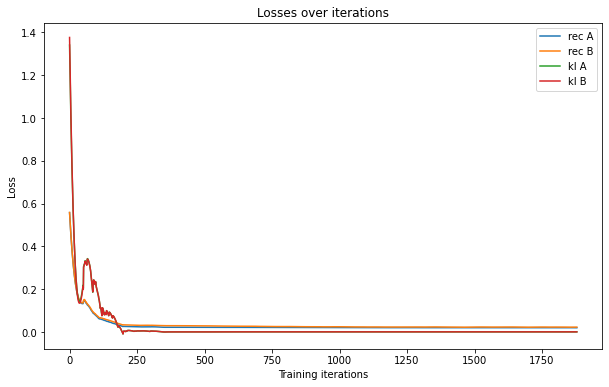

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(smooth(rec_loss_A))
plt.plot(smooth(rec_loss_B))
plt.plot(smooth(kl_loss_A))
plt.plot(smooth(kl_loss_B))
plt.legend(['rec A', 'rec B', 'kl A', 'kl B'])
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/')

## Weight network

In [50]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(3, 10, kernel_size=7)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5)
        self.fc1 = nn.Linear(40*12*12, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        h2 = torch.sigmoid(F.max_pool2d(self.conv2(h1), 2))
        h3 = torch.sigmoid(F.max_pool2d(self.conv3(h2), 2))
        h4 = h3.view(-1, 40*12*12)
        h5 = torch.sigmoid(self.fc1(h4))
        out = self.fc2(h5)
        return self.softmax(out), out

In [51]:
def n_centered_moment(x, w, n):
  if n > 1:
    c = n_centered_moment(x, w, 1)
  else:
    c = 0
  return (((x - c)**n)*w).sum(0)

In [53]:
# Initialize the networks
weight_network = WeightNet().cuda()
# Initialize the optimizers
lr = 0.01
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

criterion_w = nn.MSELoss()

# For storing results
losses_w = []

means_A = []
means_B = []

vars_A = []
vars_B = []

moments_A = []
moments_B = []

example_importances_A = []

n = 1 # n-centered moment

vae.eval()

for epoch in range(5):
    for i, data in enumerate(dataloader):
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()

        # The embeddings
        rec_A, mu_A, logvar_A = vae(img_A)
        rec_B, mu_B, logvar_B = vae(img_B)

        # The weighting process
        w_A = weight_network(img_A)[0]
        w_B = 1/len(img_B)

        # The loss function --------------------------------------------------------------------------------
        n_centered_moment_A = n_centered_moment(mu_A.detach(), w_A, n)
        n_centered_moment_B = n_centered_moment(mu_B.detach(), w_B, n)
        loss_w = criterion_w(n_centered_moment_A, n_centered_moment_B)

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step() 


        # Store values --------------------------------------------------------------------------------------
        moments_A += [n_centered_moment_A.cpu().detach().numpy()]
        moments_B += [n_centered_moment_B.cpu().detach().numpy()]

        means_A += [n_centered_moment(mu_A, w_A, 1).detach().cpu().numpy()]
        means_B += [n_centered_moment(mu_B, w_B, 1).detach().cpu().numpy()]

        vars_A += [n_centered_moment(mu_A, w_A, 2).detach().cpu().numpy()]
        vars_B += [n_centered_moment(mu_B, w_B, 2).detach().cpu().numpy()]    

        losses_w += [loss_w.item()]

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i, 'loss_w: ', loss_w.item())
            
        if i % 10000 == 0 and i != 0:
            break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 0 step 0 loss_w:  0.013045493513345718
epoch 0 step 10 loss_w:  0.010057677514851093
epoch 0 step 20 loss_w:  0.007832497358322144
epoch 0 step 30 loss_w:  0.0028446726500988007
epoch 0 step 40 loss_w:  0.0026298677548766136
epoch 1 step 0 loss_w:  0.0008607070776633918
epoch 1 step 10 loss_w:  0.004076313693076372
epoch 1 step 20 loss_w:  0.003158987034112215
epoch 1 step 30 loss_w:  0.0005942978896200657
epoch 1 step 40 loss_w:  0.002009174320846796
epoch 2 step 0 loss_w:  0.003113030456006527
epoch 2 step 10 loss_w:  0.0007483069784939289
epoch 2 step 20 loss_w:  0.004542831797152758
epoch 2 step 30 loss_w:  0.00408073840662837
epoch 2 step 40 loss_w:  0.005194106139242649
epoch 3 step 0 loss_w:  0.002595428377389908
epoch 3 step 10 loss_w:  0.00654849037528038
epoch 3 step 20 loss_w:  0.001614424865692854
epoch 3 step 30 loss_w:  0.0028971186839044094
epoch 3 step 40 loss_w:  0.00290978467091918
epoch 4 step 0 loss_w:  0.004133050329983234
epoch 4 step 10 loss_w:  0.001371030

In [54]:
moments_A = torch.Tensor(moments_A)
moments_B = torch.Tensor(moments_B)
means_A = torch.Tensor(means_A)
means_B = torch.Tensor(means_B)
vars_A = torch.Tensor(vars_A)
vars_B = torch.Tensor(vars_B)

## Results

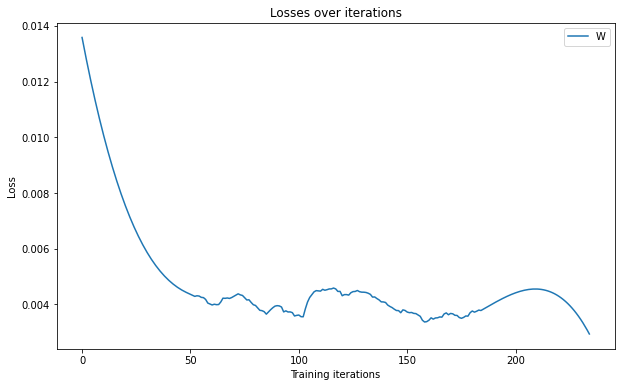

In [55]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
smoothed_losses_w = signal.savgol_filter(losses_w,101,3)
plt.plot(smoothed_losses_w)
plt.legend(['W'])
plt.show()

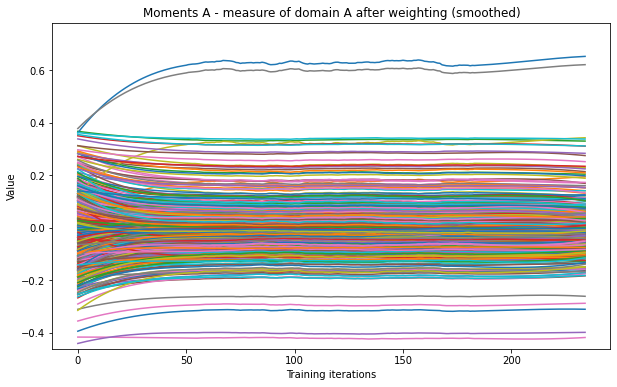

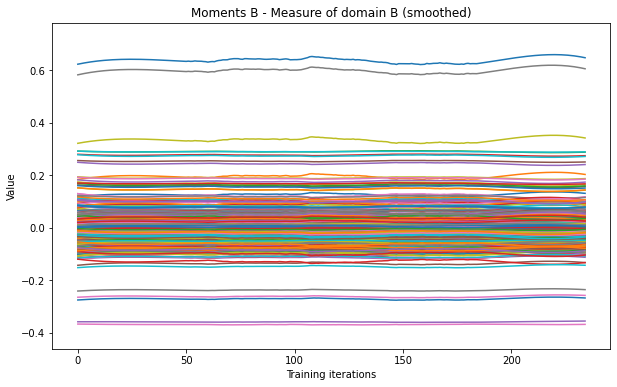

In [56]:
plt.figure(figsize=(10,6))
plt.title('Moments A - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lmin = signal.savgol_filter(moments_A,101,3,axis=0)
plt.plot(smoothed_Lmin)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Moments B - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lplus = signal.savgol_filter(moments_B,101,3,axis=0)
plt.plot(smoothed_Lplus)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

Image with weight 0.00033793941838666797


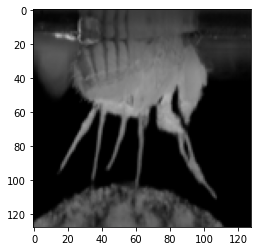

Image with weight 0.00023343818611465394


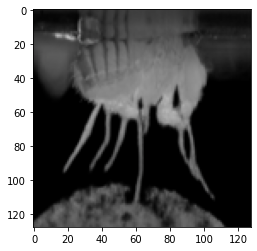

Image with weight 0.00018473509408067912


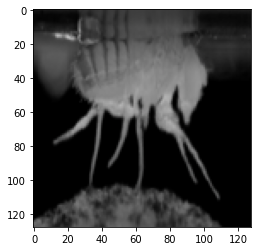

Image with weight 0.00010583705443423241


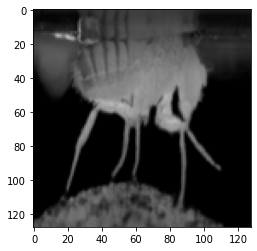

Image with weight 8.871340105542913e-05


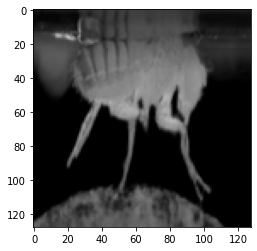

Image with weight 0.000140378309879452


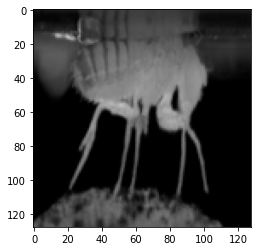

Image with weight 0.00015935490955598652


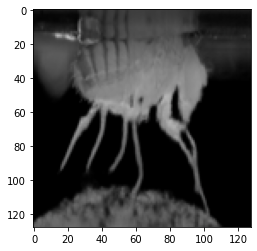

Image with weight 27.884077072143555


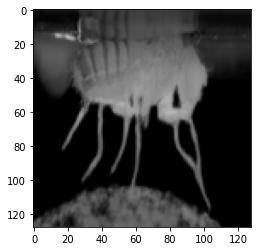

Image with weight 0.00015498029824811965


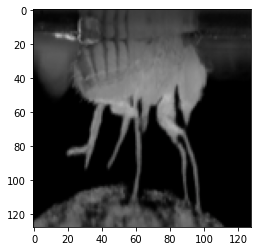

Image with weight 0.0014005131088197231


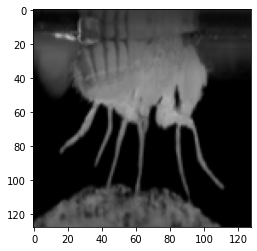

Image with weight 0.059916622936725616


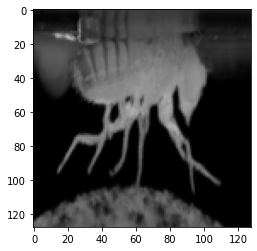

Image with weight 0.0001561180833959952


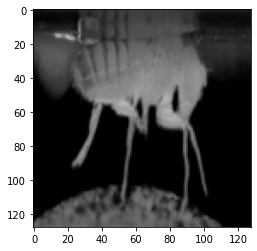

Image with weight 7.635090150870383e-05


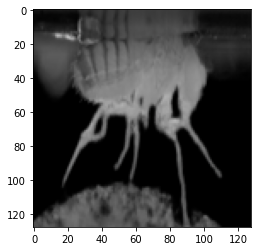

Image with weight 0.00010841792391147465


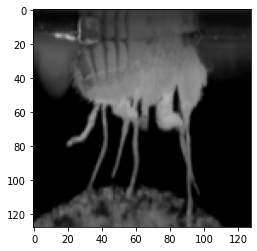

Image with weight 0.0004744876059703529


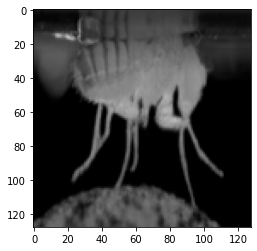

Image with weight 0.00017403131641913205


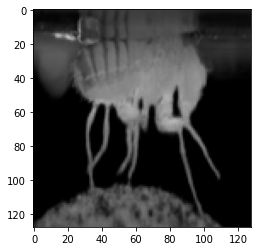

Image with weight 0.0001244220184162259


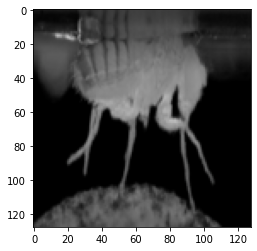

Image with weight 0.04987679049372673


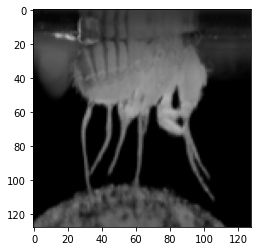

Image with weight 0.000407252722652629


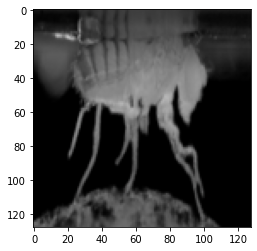

Image with weight 0.00011082270066253841


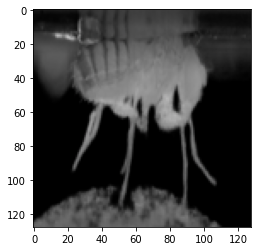

Image with weight 0.00022699761029798537


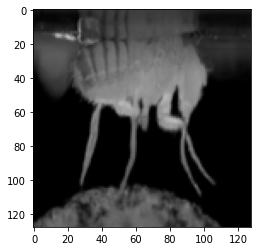

Image with weight 0.00015890102076809853


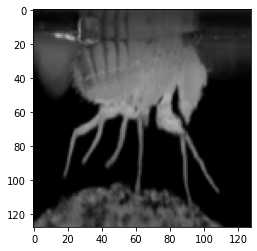

Image with weight 0.00025096238823607564


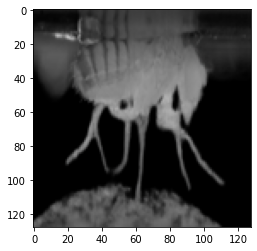

Image with weight 0.0005945870652794838


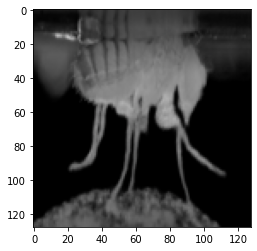

Image with weight 0.00016451877309009433


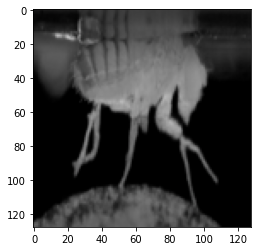

Image with weight 5.5955853895284235e-05


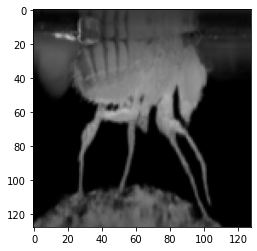

Image with weight 8.99940641829744e-05


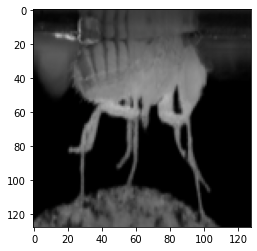

Image with weight 0.0001493641029810533


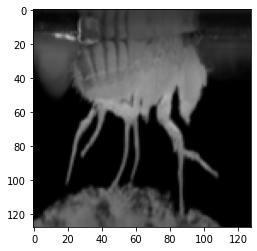

In [63]:
# These are generated images
weights = weight_network(img_A)[0]
weights *= len(weights)

for image, weight in zip(img_A, weights):
  print('Image with weight', weight.item())
  visualize(image.cpu())